In [1]:
import pandas as pd
from nltk import word_tokenize
import nltk
nltk.download('punkt')

C:\Users\DeemoJ\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\DeemoJ\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
d:\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DeemoJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data loading for Sentiment Analysis Task

In [2]:
def load_sentiment_data(directory="nusax/datasets/sentiment/"):
    """
    Load sentiment analysis data from NusaX dataset.
    Returns training, validation, and testing data along with labels for each language.
    
    Returns:
    dict: A dictionary with language keys ('indonesian', 'english', 'javanese').
            Each key contains another dictionary with keys 'train', 'valid', and 'test'.
            Each of these keys maps to a tuple of (tokenized_data, original_data), where:
                - tokenized_data: List of tokenized sentences in the corresponding language.
                - original_data: List of original sentences(in other words, not tokenized) in the corresponding language.
    
    Example usage:
        sentiment_data = load_sentiment_data()
        english_train_data = sentiment_data['english']['train']
        indonesian_valid_data = sentiment_data['indonesian']['valid']
        javanese_test_data = sentiment_data['javanese']['test']
    """
    languages = ["indonesian", "english", "javanese"]
    data = {}

    for lang in languages:
        lang_directory = directory + lang + "/"
        train_df = pd.read_csv(lang_directory + "train.csv")
        valid_df = pd.read_csv(lang_directory + "valid.csv")
        test_df = pd.read_csv(lang_directory + "test.csv")

        xtrain = [" ".join(word_tokenize(sent)) for sent in list(train_df['text'])]
        ytrain = list(train_df['label'])
        xvalid = [" ".join(word_tokenize(sent)) for sent in list(valid_df['text'])]
        yvalid = list(valid_df['label'])
        xtest = [" ".join(word_tokenize(sent)) for sent in list(test_df['text'])]
        ytest = list(test_df['label'])

        data[lang] = {
            "train": (xtrain, ytrain),
            "valid": (xvalid, yvalid),
            "test": (xtest, ytest)
        }
    
    return data

In [ ]:
# test the dataloading and print
sentiment_data = load_sentiment_data()

print("Sentiment Analysis Data:")
print(sentiment_data['indonesian'][:3])

# 1. CNN
## 1.1 Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
import nltk
nltk.download('punkt')

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential, Model
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from keras.layers import Input, Flatten, Concatenate
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DeemoJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.2 Load and Prepare the Data

In [5]:
# Load the sentiment analysis data
sentiment_data = load_sentiment_data()

# Extract Indonesian data
indonesian_train = sentiment_data['indonesian']['train']
x_train_texts, y_train = indonesian_train

indonesian_valid = sentiment_data['indonesian']['valid']
x_valid_texts, y_valid = indonesian_valid

indonesian_test = sentiment_data['indonesian']['test']
x_test_texts, y_test = indonesian_test


Tokenization and Vocabulary Building

In [6]:
# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_texts)

# Convert texts to sequences of integers
x_train_seq = tokenizer.texts_to_sequences(x_train_texts)
x_valid_seq = tokenizer.texts_to_sequences(x_valid_texts)
x_test_seq = tokenizer.texts_to_sequences(x_test_texts)


Analyze Sentence Length Distributio

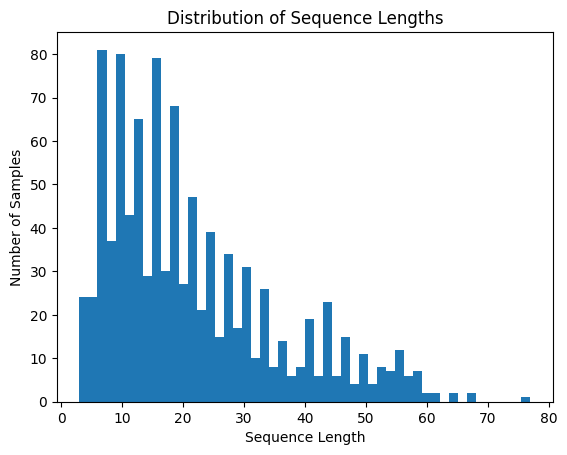

Maximum sequence length: 77
Average sequence length: 21.482
Median sequence length: 18.0
95th percentile: 51.0


In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Combine all sequences from training, validation, and test sets
all_sequences = x_train_seq + x_valid_seq + x_test_seq

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in all_sequences]

# Plot the histogram of sequence lengths
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Print statistics
print('Maximum sequence length:', np.max(sequence_lengths))
print('Average sequence length:', np.mean(sequence_lengths))
print('Median sequence length:', np.median(sequence_lengths))
print('95th percentile:', np.percentile(sequence_lengths, 95))


Padding Sequences

In [85]:
# Define maximum sequence length
MAX_SEQUENCE_LENGTH = 60

# Pad sequences with zeros
x_train_padded = pad_sequences(x_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
x_valid_padded = pad_sequences(x_valid_seq, maxlen=MAX_SEQUENCE_LENGTH)
x_test_padded = pad_sequences(x_test_seq, maxlen=MAX_SEQUENCE_LENGTH)


Encoding Labels

In [86]:
# Encode labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y_train_encoded))
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_valid_categorical = to_categorical(y_valid_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)


## 1.3 Build-Train-Evaluate the CNN Model

In [ ]:
# import numpy as np
# from keras.models import Model
# from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, concatenate
# from keras.layers import Dense, Dropout
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# Vocabulary size and embedding dimension
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for reserved index
embedding_dim = 200

# 输入层
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))

# 嵌入层
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim, 
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable=True)(input_layer)

# 卷积核大小列表，捕捉不同 n-gram 特征
filter_sizes = [3, 4, 5]
num_filters = 100

# 卷积和池化层
conv_blocks = []
for size in filter_sizes:
    conv = Conv1D(filters=num_filters,
                  kernel_size=size,
                  activation='relu',
                  padding='valid')(embedding_layer)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

# 拼接所有卷积通道的输出
concat_layer = concatenate(conv_blocks, axis=1)

# 添加 Dropout 防止过拟合
dropout_layer = Dropout(0.5)(concat_layer)

# 全连接层
dense_layer = Dense(100, activation='relu')(dropout_layer)

# 输出层
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# 构建模型
model = Model(inputs=input_layer, outputs=output_layer)

In [132]:
# Compile the model
from keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

# Print model summary
model.summary()

# 设置回调函数
model_checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True)


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 60, 200)      559000      ['input_22[0][0]']               
                                                                                                  
 conv1d_60 (Conv1D)             (None, 58, 100)      60100       ['embedding_20[0][0]']           
                                                                                                  
 conv1d_61 (Conv1D)             (None, 57, 100)      80100       ['embedding_20[0][0]']           
                                                                                           

Train the model

In [133]:
# Train the model
history = model.fit(
    x_train_padded, y_train_categorical,
    batch_size=64,
    epochs=100,
    validation_data=(x_valid_padded, y_valid_categorical),
    callbacks=[model_checkpoint]
)


Epoch 1/100
8/8 [==============================] - 2s 84ms/step - loss: 1.0952 - accuracy: 0.3700 - val_loss: 1.0865 - val_accuracy: 0.3800
Epoch 2/100
8/8 [==============================] - 0s 58ms/step - loss: 1.0768 - accuracy: 0.4060 - val_loss: 1.0757 - val_accuracy: 0.3800
Epoch 3/100
8/8 [==============================] - 0s 59ms/step - loss: 1.0681 - accuracy: 0.4280 - val_loss: 1.0675 - val_accuracy: 0.3900
Epoch 4/100
8/8 [==============================] - 0s 59ms/step - loss: 1.0536 - accuracy: 0.4200 - val_loss: 1.0610 - val_accuracy: 0.4000
Epoch 5/100
8/8 [==============================] - 0s 63ms/step - loss: 1.0407 - accuracy: 0.4580 - val_loss: 1.0553 - val_accuracy: 0.4100
Epoch 6/100
8/8 [==============================] - 0s 60ms/step - loss: 1.0265 - accuracy: 0.5200 - val_loss: 1.0501 - val_accuracy: 0.4200
Epoch 7/100
8/8 [==============================] - 0s 62ms/step - loss: 1.0207 - accuracy: 0.5120 - val_loss: 1.0455 - val_accuracy: 0.4300
Epoch 8/100
8/8 [===

Evaluate the Model

In [ ]:
# load the best model
model.load_weights('best_cnn_model.h5')
# model.load_weights('best_cnn_model1.h5')

In [136]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(x_test_padded, y_test_categorical)
print('Test Accuracy:', test_acc)


13/13 [==============================] - 0s 8ms/step - loss: 0.5794 - accuracy: 0.7825
Test Accuracy: 0.7825000286102295


In [137]:
# Predictions
y_pred_probs = model.predict(x_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print('Classification Report:')
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_mat = confusion_matrix(y_test_encoded, y_pred)


13/13 [==============================] - 0s 9ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.78      0.76       153
     neutral       0.70      0.67      0.68        96
    positive       0.87      0.86      0.87       151

    accuracy                           0.78       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.78      0.78      0.78       400



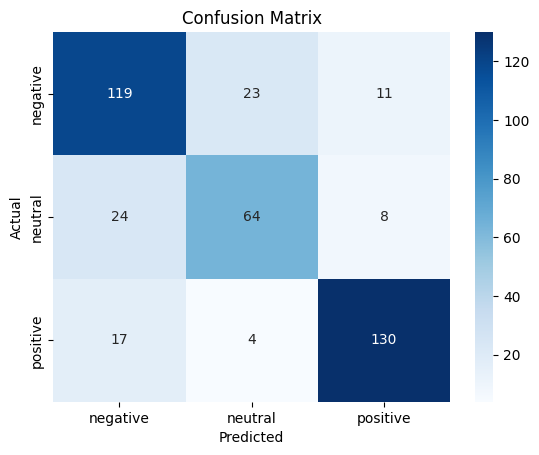

In [138]:
# Plot confusion matrix
labels = label_encoder.classes_
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Test with Your Own Sentences

In [ ]:
# Function to predict sentiment
def predict_sentiment(text):
    tokens = word_tokenize(text)
    sequence = tokenizer.texts_to_sequences([" ".join(tokens)])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
    pred_prob = model.predict(padded_sequence)
    pred_class = np.argmax(pred_prob, axis=1)
    sentiment = label_encoder.inverse_transform(pred_class)
    return sentiment[0]

# Test sentences
test_texts = [
    "Saya sangat senang dengan pelayanan toko ini.",  # Positive sentiment - I am very happy with the service of this store.
    "Produk ini sangat buruk dan tidak berguna.",     # Negative sentiment - This product is very bad and useless.
    "Kualitasnya biasa saja, tidak terlalu bagus.",   # Neutral sentiment - The quality is just okay, not too good.

    "Saya sangat senang dengan pelayanan toko ini. Produk ini sangat buruk dan tidak berguna.",  # Mixed sentiment - I am very happy with the service of this store. This product is very bad and useless.
    "Produk ini sangat bagus, tetapi sayangnya harganya terlalu mahal.",  # Mixed sentiment - This product is very good, but unfortunately the price is too expensive.
    
    "Saya sangat bahagia hari ini",  # Positive sentiment - "I am very happy today"
    "Cuaca sangat buruk",            # Negative sentiment - "The weather is very bad"
    "Saya suka belajar bahasa",      # Positive sentiment - "I like learning languages"
    "Ini adalah hari yang menyedihkan" # Negative sentiment - "This is a sad day"
]

# Predict sentiments
for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment}")
    print()


1/1 [==============================] - 0s 23ms/step
Text: Saya sangat senang dengan pelayanan toko ini.
Predicted Sentiment: positive

1/1 [==============================] - 0s 29ms/step
Text: Produk ini sangat buruk dan tidak berguna.
Predicted Sentiment: negative

1/1 [==============================] - 0s 30ms/step
Text: Kualitasnya biasa saja, tidak terlalu bagus.
Predicted Sentiment: negative

